<a href="https://colab.research.google.com/github/KimiaDN/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraires

In [ ]:
import pandas as pd
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
import re
from nltk.sentiment.util import *
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import numpy as np
import string
from  nltk.stem import SnowballStemmer
nltk.download('words')
nltk.download('punkt')
from keras.layers import Input,Dense,Activation,concatenate
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Concatenate
from scipy.sparse import csr_matrix
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# PreProcessing

## Load the Dataset

In [ ]:
df = pd.read_csv('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Watches_v1_00.tsv.gz',on_bad_lines = 'skip',sep='\t')

In [ ]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [ ]:
df. shape

(960204, 15)

## Drop unwanted column

In [ ]:
df.drop(['marketplace','customer_id','review_id','product_id','product_parent','product_title','product_category','helpful_votes',	'total_votes',	'vine','verified_purchase','review_date'	], inplace = True,axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   star_rating      960204 non-null  int64 
 1   review_headline  960197 non-null  object
 2   review_body      960056 non-null  object
dtypes: int64(1), object(2)
memory usage: 22.0+ MB


In [ ]:
np.sum(df.isnull().any(axis=1))

155

In [ ]:
print(df.isnull().any(axis=1))

0         False
1         False
2         False
3         False
4         False
          ...  
960199    False
960200    False
960201    False
960202    False
960203    False
Length: 960204, dtype: bool


In [ ]:
df.isna().any()

star_rating        False
review_headline     True
review_body         True
dtype: bool

In [ ]:
nan_in_col  = df[df['review_headline'].isna()]

In [ ]:
print(nan_in_col)

        star_rating review_headline  \
238363            1             NaN   
347249            1             NaN   
497388            3             NaN   
525240            3             NaN   
525400            2             NaN   
555184            3             NaN   
855490            1             NaN   

                                              review_body  
238363  It is really big and heavy but I liked it a lo...  
347249                                I didn't order this  
497388  I am always searching for things on Amazon.ca ...  
525240  Well it was for a gift so I do not know if the...  
525400  I bought this watch for my daughter and when i...  
555184  Pretty but not as pretty as I thought it would...  
855490  I was looking to purchase a men's watch, but a...  


## Drop NaN column

In [ ]:
df.dropna(inplace = True)
df.reset_index(inplace=True)

In [ ]:
np.sum(df.isnull().any(axis=1))

0

In [ ]:
df.isna().any()

index              False
star_rating        False
review_headline    False
review_body        False
dtype: bool

In [ ]:
df['review_headline']=df['review_headline'].str.lower()
df['review_headline'].tail()

960044                 great prize - but size??
960045                     a very classy watch!
960046                    this is a great watch
960047                  now watt a minute here.
960048    1/10 watt difference for hearing aids
Name: review_headline, dtype: object

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TAG_RE = re.compile(r'<[^>]+>')
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

## delete HTML tag and stopwords and Stemming

In [ ]:
def preprocess(text, stem=True):
    # Remove link,user and special characters
    text = TAG_RE.sub('', text)
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.head(50)

,index,star_rating,review_headline,review_body
0,0,5,five stars,Absolutely love this watch! Get compliments al...
1,1,5,i love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.
2,2,2,two stars,Scratches
3,3,5,five stars,"It works well on me. However, I found cheaper ..."
4,4,4,"beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...
5,5,5,no complaints,"i love this watch for my purpose, about the pe..."
6,6,5,five stars,"for my wife and she loved it, looks great and ..."
7,7,1,i was about to buy this thinking it was a ...,I was about to buy this thinking it was a Swis...
8,8,5,perfect watch!,Watch is perfect. Rugged with the metal &#34;B...
9,9,4,great quality and build,Great quality and build.<br />The motors are r...


## Apply PreProcessing

In [ ]:
df['review_headline'] = df['review_headline'].apply(lambda x: preprocess(x))

In [ ]:
df['review_body'] = df['review_body'].apply(lambda x: preprocess(x))

In [ ]:
df.head(50)

,index,star_rating,review_headline,review_body
0,0,5,five star,absolut love watch get compliment almost everi...
1,1,5,love thiswatch keep time wonder,love watch keep time wonder
2,2,2,two star,scratch
3,3,5,five star,work well howev found cheaper price place make...
4,4,4,beauti face cheap sound link,beauti watch face band look nice around link m...
5,5,5,complaint,love watch purpos peopl complain done research...
6,6,5,five star,wife love look great great price
7,7,1,buy think,buy think swiss armi infantri watch descript u...
8,8,5,perfect watch,watch perfect rug metal bull bar red accent gr...
9,9,4,great qualiti build,great qualiti build motor realli silent fiddl ...


## Check possible words

In [ ]:
words = set(nltk.corpus.words.words())
def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in words or not w.isalpha())

df['review_body'] = df['review_body'].apply(clean_sent)


In [ ]:
df.head(50)

,index,star_rating,review_headline,review_body
0,0,5,five star,love watch get compliment almost time wear
1,1,5,love thiswatch keep time wonder,love watch keep time wonder
2,2,2,two star,scratch
3,3,5,five star,work well found price place make
4,4,4,beauti face cheap sound link,beauti watch face band look nice around link m...
5,5,5,complaint,love watch complain done research better buy dumb
6,6,5,five star,wife love look great great price
7,7,1,buy think,buy think swiss watch descript use word must f...
8,8,5,perfect watch,watch perfect rug metal bull bar red accent gr...
9,9,4,great qualiti build,great build motor silent set watch alway use


In [ ]:
df.head()

,index,star_rating,review_headline,review_body
0,0,5,five star,love watch get compliment almost time wear
1,1,5,love thiswatch keep time wonder,love watch keep time wonder
2,2,2,two star,scratch
3,3,5,five star,work well found price place make
4,4,4,beauti face cheap sound link,beauti watch face band look nice around link m...


## Convert star ratings to Posetive, Negative and Neutral

In [ ]:
star_rating = np.array(df['star_rating'])
rate_class = np.empty_like(star_rating)
for i  in range(len(rate_class)):
  if star_rating[i] >= 4:
    rate_class[i] = 2  # class1 : Posative Class
  elif star_rating[i] <= 2:
    rate_class[i] = 0  # class2 : Negative class
  elif star_rating[i] == 3:
    rate_class[i] = 1  # class3 : Neutral class

df['star_rating'] = rate_class

## Convert data to list

In [ ]:
headline = df['review_headline'].to_list()
body = df['review_body'].to_list()
rate = df['star_rating'].to_list()

## Using tf-idf Vectorizer

In [ ]:
#body tf-idf
tfidf_b = TfidfVectorizer(max_features=10000)
result_b = tfidf_b.fit_transform(body)

In [ ]:
#headline tf-idf
tfidf_h = TfidfVectorizer(max_features=10000)
result_h = tfidf_h.fit_transform(headline)

In [ ]:
# get indexing
print('\nWord indexes:')
print(tfidf_h.vocabulary_)

# display tf-idf values
print('\ntf-idf value:')
print(result_h)



Word indexes:
{'five': 3245, 'star': 8193, 'love': 5105, 'thiswatch': 8733, 'keep': 4705, 'time': 8804, 'wonder': 9760, 'two': 9071, 'beauti': 754, 'face': 3050, 'cheap': 1466, 'sound': 8057, 'link': 4988, 'complaint': 1755, 'buy': 1241, 'think': 8725, 'perfect': 6354, 'watch': 9522, 'great': 3772, 'qualiti': 6880, 'build': 1180, 'satisfi': 7474, 'good': 3679, 'product': 6746, 'three': 8750, 'worth': 9809, 'differ': 2323, 'thewatch': 8713, 'attract': 520, 'easi': 2620, 'read': 6992, 'stylish': 8360, 'look': 5057, 'work': 9784, 'use': 9289, 'slim': 7886, 'fit': 3242, 'awatch': 580, 'bought': 1037, 'quick': 6905, 'sale': 7431, 'thing': 8723, 'four': 3368, 'thought': 8744, 'somewher': 8028, 'could': 1902, 'swim': 8511, 'impress': 4306, 'epitom': 2830, 'form': 3348, 'function': 3448, 'surpass': 8459, 'expect': 2991, 'classi': 1606, 'nice': 5815, 'band': 655, 'littl': 5005, 'small': 7904, 'one': 6033, 'lot': 5088, 'featur': 3140, 'amaz': 273, 'everyth': 2917, 'safe': 7422, 'secur': 7579, '

In [ ]:
# get indexing
print('\nWord indexes:')
print(tfidf_b.vocabulary_)

# display tf-idf values
print('\ntf-idf value:')
print(result_b)


Word indexes:
{'love': 4933, 'watch': 9624, 'get': 3448, 'compliment': 1754, 'almost': 197, 'time': 8823, 'wear': 9652, 'keep': 4498, 'wonder': 9830, 'scratch': 7315, 'work': 9849, 'well': 9676, 'found': 3238, 'price': 6470, 'place': 6254, 'make': 5029, 'beauti': 667, 'face': 2846, 'band': 581, 'look': 4903, 'nice': 5614, 'around': 376, 'link': 4827, 'swing': 8489, 'back': 522, 'forth': 3224, 'wrist': 9895, 'embarrass': 2658, 'front': 3302, 'enthusiast': 2710, 'nake': 5526, 'eye': 2834, 'afar': 89, 'tell': 8638, 'cheap': 1434, 'fold': 3168, 'polish': 6350, 'brush': 1084, 'tight': 8814, 'part': 6021, 'new': 5603, 'member': 5193, 'collect': 1695, 'great': 3637, 'week': 9664, 'far': 2891, 'kept': 4507, 'good': 3564, 'day': 2139, 'typic': 9160, 'complain': 1747, 'done': 2441, 'research': 6953, 'better': 744, 'buy': 1182, 'dumb': 2560, 'wife': 9767, 'think': 8730, 'swiss': 8493, 'descript': 2245, 'use': 9398, 'word': 9846, 'must': 5502, 'fraud': 3266, 'offer': 5743, 'design': 2247, 'perfec

## Splitting the Data

In [ ]:
#spliting data into train, dev, test
xh = result_h
xb = result_b
y = np.array(rate)
xh_train, xh_test, xb_train, xb_test, y_train, y_test = train_test_split(xh, xb, y, test_size=0.4)
xh_dev, xh_test, xb_dev, xb_test, y_dev, y_test = train_test_split(xh_test, xb_test, y_test, test_size=0.5)

#Model

##Naive Bayes


In [ ]:
csr_matrix.sort_indices(xh_train)
csr_matrix.sort_indices(xh_dev)
csr_matrix.sort_indices(xh_test)
csr_matrix.sort_indices(xb_train)
csr_matrix.sort_indices(xb_dev)
csr_matrix.sort_indices(xb_test)

In [ ]:
x_train = hstack((xh_train, xb_train))
x_test = hstack((xh_test, xb_test))

In [ ]:
model = MultinomialNB(force_alpha=True)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

### Report

In [ ]:
print(classification_report(y_test, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74     27641
           1       0.60      0.30      0.40     15850
           2       0.91      0.97      0.94    148519

    accuracy                           0.88    192010
   macro avg       0.76      0.66      0.69    192010
weighted avg       0.86      0.88      0.86    192010



Text(95.72222222222221, 0.5, 'Truth')

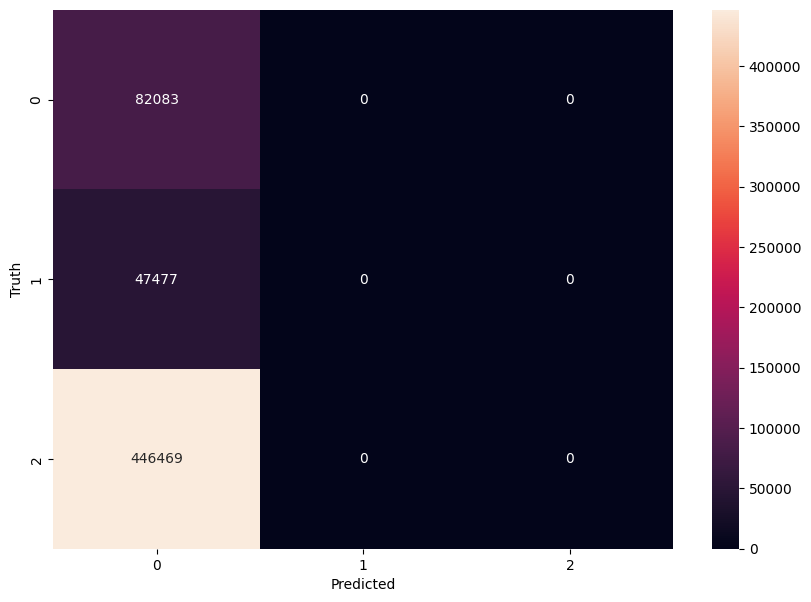

In [ ]:
y_predicted_train = model.predict(x_train)
y_predicted_labels_train = [np.argmax(i) for i in y_predicted_train]
cm = tf.math.confusion_matrix(labels=y_train,predictions=y_predicted_labels_train)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Neural Network

In [ ]:
x_train = [xh_train,xb_train]
x_dev = [xh_dev, xb_dev]
x_test = [xh_test,xb_test]

In [ ]:
y_trainOH = to_categorical(y_train)[:, 0:3]
y_devOH = to_categorical(y_dev)[:, 0:3]
y_testOH = to_categorical(y_test)[:, 0:3]
validation_data = (x_dev[1], y_devOH)

In [ ]:
y_trainOH.shape, y_train.shape

((576029, 3), (576029,))

In [ ]:
input1 = Input(shape=x_train[0].shape[1:],sparse=True)
input2 = Input(shape=x_train[1].shape[1:],sparse=True)
x = Dense(256,activation='relu')(input1)
a = Dense(256,activation='relu')(input2)

merge = Concatenate()([x, a])

x = Dense(64,activation='relu')(merge)
output = Dense(3,activation='softmax')(x)

model = Model(inputs=[input1,input2],outputs=output)
model.compile(loss="categorical_crossentropy",optimizer=Adam(0.01),metrics=['categorical_accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(x_train, y_trainOH,epochs=3, validation_data = (x_test ,y_testOH))

Epoch 1/3
18001/18001 [==============================] - 237s 13ms/step - loss: 0.3028 - categorical_accuracy: 0.8891 - val_loss: 0.2876 - val_categorical_accuracy: 0.8944
Epoch 2/3
18001/18001 [==============================] - 152s 8ms/step - loss: 0.2699 - categorical_accuracy: 0.9001 - val_loss: 0.2940 - val_categorical_accuracy: 0.8947
Epoch 3/3
 9733/18001 [===============>..............] - ETA: 57s - loss: 0.2429 - categorical_accuracy: 0.9098

In [ ]:
y_pred = model.predict(x_test)

### Report

In [ ]:
z = np.argmax(y_pred, axis = 1)
z = to_categorical(z)
z

In [ ]:
print(classification_report(y_testOH, z,zero_division=0))

In [ ]:
y_predicted_train = model.predict(x_train)
y_predicted_labels_train = [np.argmax(i) for i in y_predicted_train]
cm = tf.math.confusion_matrix(labels=y_train,predictions=y_predicted_labels_train)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')